# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, hidden4_size, hidden5_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.Tanh(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.Tanh(),
            nn.Linear(hidden3_size, hidden4_size),
            nn.Tanh(),
            nn.Linear(hidden4_size, hidden5_size),
            nn.Tanh(),
            nn.Linear(hidden5_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=200, out_features=200, bias=True)
    (7): Tanh()
    (8): Linear(in_features=200, out_features=200, bias=True)
    (9): Tanh()
    (10): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/12, Loss: 0.8055
Epoch 1/200, Iteration 2/12, Loss: 0.5539
Epoch 1/200, Iteration 3/12, Loss: 2.3976
Epoch 1/200, Iteration 4/12, Loss: 1.0212
Epoch 1/200, Iteration 5/12, Loss: 1.1834
Epoch 1/200, Iteration 6/12, Loss: 0.8478
Epoch 1/200, Iteration 7/12, Loss: 0.7319
Epoch 1/200, Iteration 8/12, Loss: 0.5919
Epoch 1/200, Iteration 9/12, Loss: 0.5599
Epoch 1/200, Iteration 10/12, Loss: 0.5635
Epoch 1/200, Iteration 11/12, Loss: 0.4715
Epoch 1/200, Iteration 12/12, Loss: 0.6465
Epoch 1/200, Iteration 13/12, Loss: 0.4752
Train Error: 
 Accuracy: 60.38%, Avg loss: 0.548408, MRE: 0.397069, MAE: 0.080688 

Test Error: 
 Accuracy: 60.0%, Avg loss: 0.515255, MRE: 0.343715, MAE: 0.072706 

Epoch 2/200, Iteration 1/12, Loss: 0.5424
Epoch 2/200, Iteration 2/12, Loss: 0.4340
Epoch 2/200, Iteration 3/12, Loss: 0.4617
Epoch 2/200, Iteration 4/12, Loss: 0.5170
Epoch 2/200, Iteration 5/12, Loss: 0.3900
Epoch 2/200, Iteration 6/12, Loss: 0.3862
Epoch 2/200, Iteration 7/12, Los

Train Error: 
 Accuracy: 75.25%, Avg loss: 0.154101, MRE: 0.122292, MAE: 0.021114 

Test Error: 
 Accuracy: 74.5%, Avg loss: 0.135711, MRE: 0.093099, MAE: 0.018590 

Epoch 13/200, Iteration 1/12, Loss: 0.1584
Epoch 13/200, Iteration 2/12, Loss: 0.1291
Epoch 13/200, Iteration 3/12, Loss: 0.1582
Epoch 13/200, Iteration 4/12, Loss: 0.1246
Epoch 13/200, Iteration 5/12, Loss: 0.1316
Epoch 13/200, Iteration 6/12, Loss: 0.2000
Epoch 13/200, Iteration 7/12, Loss: 0.2174
Epoch 13/200, Iteration 8/12, Loss: 0.1723
Epoch 13/200, Iteration 9/12, Loss: 0.2143
Epoch 13/200, Iteration 10/12, Loss: 0.2141
Epoch 13/200, Iteration 11/12, Loss: 0.1640
Epoch 13/200, Iteration 12/12, Loss: 0.2119
Epoch 13/200, Iteration 13/12, Loss: 0.3242
Train Error: 
 Accuracy: 33.12%, Avg loss: 0.250404, MRE: 0.239802, MAE: 0.034132 

Test Error: 
 Accuracy: 33.0%, Avg loss: 0.250379, MRE: 0.214065, MAE: 0.033796 

Epoch 14/200, Iteration 1/12, Loss: 0.2608
Epoch 14/200, Iteration 2/12, Loss: 0.1614
Epoch 14/200, Itera

Epoch 24/200, Iteration 6/12, Loss: 0.1443
Epoch 24/200, Iteration 7/12, Loss: 0.1559
Epoch 24/200, Iteration 8/12, Loss: 0.1213
Epoch 24/200, Iteration 9/12, Loss: 0.1192
Epoch 24/200, Iteration 10/12, Loss: 0.1293
Epoch 24/200, Iteration 11/12, Loss: 0.1490
Epoch 24/200, Iteration 12/12, Loss: 0.1033
Epoch 24/200, Iteration 13/12, Loss: 0.1450
Train Error: 
 Accuracy: 95.5%, Avg loss: 0.126393, MRE: 0.087171, MAE: 0.016891 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.126981, MRE: 0.079764, MAE: 0.016687 

Epoch 25/200, Iteration 1/12, Loss: 0.1274
Epoch 25/200, Iteration 2/12, Loss: 0.1346
Epoch 25/200, Iteration 3/12, Loss: 0.1737
Epoch 25/200, Iteration 4/12, Loss: 0.1366
Epoch 25/200, Iteration 5/12, Loss: 0.1665
Epoch 25/200, Iteration 6/12, Loss: 0.2010
Epoch 25/200, Iteration 7/12, Loss: 0.1495
Epoch 25/200, Iteration 8/12, Loss: 0.1807
Epoch 25/200, Iteration 9/12, Loss: 0.1499
Epoch 25/200, Iteration 10/12, Loss: 0.2202
Epoch 25/200, Iteration 11/12, Loss: 0.1582
Epoch 25/200

Train Error: 
 Accuracy: 98.62%, Avg loss: 0.029685, MRE: 0.026178, MAE: 0.003903 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.030241, MRE: 0.019846, MAE: 0.003912 

Epoch 36/200, Iteration 1/12, Loss: 0.0270
Epoch 36/200, Iteration 2/12, Loss: 0.0302
Epoch 36/200, Iteration 3/12, Loss: 0.0327
Epoch 36/200, Iteration 4/12, Loss: 0.0316
Epoch 36/200, Iteration 5/12, Loss: 0.0286
Epoch 36/200, Iteration 6/12, Loss: 0.0400
Epoch 36/200, Iteration 7/12, Loss: 0.0347
Epoch 36/200, Iteration 8/12, Loss: 0.0355
Epoch 36/200, Iteration 9/12, Loss: 0.0350
Epoch 36/200, Iteration 10/12, Loss: 0.0333
Epoch 36/200, Iteration 11/12, Loss: 0.0368
Epoch 36/200, Iteration 12/12, Loss: 0.0260
Epoch 36/200, Iteration 13/12, Loss: 0.0295
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.029684, MRE: 0.024149, MAE: 0.003964 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.034490, MRE: 0.021205, MAE: 0.004653 

Epoch 37/200, Iteration 1/12, Loss: 0.0255
Epoch 37/200, Iteration 2/12, Loss: 0.0357
Epoch 37/200, Iterat

Epoch 47/200, Iteration 6/12, Loss: 0.0288
Epoch 47/200, Iteration 7/12, Loss: 0.0276
Epoch 47/200, Iteration 8/12, Loss: 0.0259
Epoch 47/200, Iteration 9/12, Loss: 0.0279
Epoch 47/200, Iteration 10/12, Loss: 0.0357
Epoch 47/200, Iteration 11/12, Loss: 0.0294
Epoch 47/200, Iteration 12/12, Loss: 0.0278
Epoch 47/200, Iteration 13/12, Loss: 0.0311
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.023236, MRE: 0.018308, MAE: 0.003231 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.029102, MRE: 0.018496, MAE: 0.003921 

Epoch 48/200, Iteration 1/12, Loss: 0.0246
Epoch 48/200, Iteration 2/12, Loss: 0.0265
Epoch 48/200, Iteration 3/12, Loss: 0.0283
Epoch 48/200, Iteration 4/12, Loss: 0.0272
Epoch 48/200, Iteration 5/12, Loss: 0.0273
Epoch 48/200, Iteration 6/12, Loss: 0.0348
Epoch 48/200, Iteration 7/12, Loss: 0.0354
Epoch 48/200, Iteration 8/12, Loss: 0.0281
Epoch 48/200, Iteration 9/12, Loss: 0.0322
Epoch 48/200, Iteration 10/12, Loss: 0.0353
Epoch 48/200, Iteration 11/12, Loss: 0.0234
Epoch 48/20

Epoch 58/200, Iteration 12/12, Loss: 0.0183
Epoch 58/200, Iteration 13/12, Loss: 0.0215
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.020325, MRE: 0.012664, MAE: 0.002815 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.026172, MRE: 0.015932, MAE: 0.003561 

Epoch 59/200, Iteration 1/12, Loss: 0.0211
Epoch 59/200, Iteration 2/12, Loss: 0.0204
Epoch 59/200, Iteration 3/12, Loss: 0.0214
Epoch 59/200, Iteration 4/12, Loss: 0.0169
Epoch 59/200, Iteration 5/12, Loss: 0.0169
Epoch 59/200, Iteration 6/12, Loss: 0.0206
Epoch 59/200, Iteration 7/12, Loss: 0.0255
Epoch 59/200, Iteration 8/12, Loss: 0.0191
Epoch 59/200, Iteration 9/12, Loss: 0.0202
Epoch 59/200, Iteration 10/12, Loss: 0.0205
Epoch 59/200, Iteration 11/12, Loss: 0.0176
Epoch 59/200, Iteration 12/12, Loss: 0.0190
Epoch 59/200, Iteration 13/12, Loss: 0.0278
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.020030, MRE: 0.015832, MAE: 0.002687 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.026800, MRE: 0.017677, MAE: 0.003530 

Epoch 60/200, Ite

Epoch 70/200, Iteration 11/12, Loss: 0.0342
Epoch 70/200, Iteration 12/12, Loss: 0.0211
Epoch 70/200, Iteration 13/12, Loss: 0.0266
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.023922, MRE: 0.015843, MAE: 0.003464 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.030669, MRE: 0.018442, MAE: 0.004384 

Epoch 71/200, Iteration 1/12, Loss: 0.0243
Epoch 71/200, Iteration 2/12, Loss: 0.0235
Epoch 71/200, Iteration 3/12, Loss: 0.0265
Epoch 71/200, Iteration 4/12, Loss: 0.0226
Epoch 71/200, Iteration 5/12, Loss: 0.0219
Epoch 71/200, Iteration 6/12, Loss: 0.0238
Epoch 71/200, Iteration 7/12, Loss: 0.0230
Epoch 71/200, Iteration 8/12, Loss: 0.0197
Epoch 71/200, Iteration 9/12, Loss: 0.0228
Epoch 71/200, Iteration 10/12, Loss: 0.0172
Epoch 71/200, Iteration 11/12, Loss: 0.0232
Epoch 71/200, Iteration 12/12, Loss: 0.0187
Epoch 71/200, Iteration 13/12, Loss: 0.0184
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.019379, MRE: 0.014284, MAE: 0.002533 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.024899, MRE:

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.007219, MRE: 0.005949, MAE: 0.000963 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.016819, MRE: 0.010758, MAE: 0.002207 

Epoch 83/200, Iteration 1/12, Loss: 0.0078
Epoch 83/200, Iteration 2/12, Loss: 0.0064
Epoch 83/200, Iteration 3/12, Loss: 0.0069
Epoch 83/200, Iteration 4/12, Loss: 0.0060
Epoch 83/200, Iteration 5/12, Loss: 0.0062
Epoch 83/200, Iteration 6/12, Loss: 0.0080
Epoch 83/200, Iteration 7/12, Loss: 0.0063
Epoch 83/200, Iteration 8/12, Loss: 0.0065
Epoch 83/200, Iteration 9/12, Loss: 0.0074
Epoch 83/200, Iteration 10/12, Loss: 0.0075
Epoch 83/200, Iteration 11/12, Loss: 0.0072
Epoch 83/200, Iteration 12/12, Loss: 0.0076
Epoch 83/200, Iteration 13/12, Loss: 0.0069
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.006930, MRE: 0.005338, MAE: 0.000938 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.016647, MRE: 0.010159, MAE: 0.002189 

Epoch 84/200, Iteration 1/12, Loss: 0.0068
Epoch 84/200, Iteration 2/12, Loss: 0.0073
Epoch 84/200, Itera

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.005958, MRE: 0.004912, MAE: 0.000797 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.016135, MRE: 0.010142, MAE: 0.002127 

Epoch 95/200, Iteration 1/12, Loss: 0.0070
Epoch 95/200, Iteration 2/12, Loss: 0.0059
Epoch 95/200, Iteration 3/12, Loss: 0.0063
Epoch 95/200, Iteration 4/12, Loss: 0.0055
Epoch 95/200, Iteration 5/12, Loss: 0.0079
Epoch 95/200, Iteration 6/12, Loss: 0.0058
Epoch 95/200, Iteration 7/12, Loss: 0.0064
Epoch 95/200, Iteration 8/12, Loss: 0.0074
Epoch 95/200, Iteration 9/12, Loss: 0.0058
Epoch 95/200, Iteration 10/12, Loss: 0.0069
Epoch 95/200, Iteration 11/12, Loss: 0.0066
Epoch 95/200, Iteration 12/12, Loss: 0.0067
Epoch 95/200, Iteration 13/12, Loss: 0.0065
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.006404, MRE: 0.005362, MAE: 0.000878 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.016595, MRE: 0.010762, MAE: 0.002197 

Epoch 96/200, Iteration 1/12, Loss: 0.0071
Epoch 96/200, Iteration 2/12, Loss: 0.0064
Epoch 96/200, Itera

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.006108, MRE: 0.004630, MAE: 0.000832 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.015932, MRE: 0.009859, MAE: 0.002113 

Epoch 107/200, Iteration 1/12, Loss: 0.0061
Epoch 107/200, Iteration 2/12, Loss: 0.0057
Epoch 107/200, Iteration 3/12, Loss: 0.0064
Epoch 107/200, Iteration 4/12, Loss: 0.0063
Epoch 107/200, Iteration 5/12, Loss: 0.0066
Epoch 107/200, Iteration 6/12, Loss: 0.0056
Epoch 107/200, Iteration 7/12, Loss: 0.0060
Epoch 107/200, Iteration 8/12, Loss: 0.0068
Epoch 107/200, Iteration 9/12, Loss: 0.0049
Epoch 107/200, Iteration 10/12, Loss: 0.0065
Epoch 107/200, Iteration 11/12, Loss: 0.0055
Epoch 107/200, Iteration 12/12, Loss: 0.0062
Epoch 107/200, Iteration 13/12, Loss: 0.0063
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.005870, MRE: 0.004814, MAE: 0.000795 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.016128, MRE: 0.010122, MAE: 0.002141 

Epoch 108/200, Iteration 1/12, Loss: 0.0064
Epoch 108/200, Iteration 2/12, Loss: 0.0066
Epoc

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.005964, MRE: 0.004571, MAE: 0.000813 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.016179, MRE: 0.010081, MAE: 0.002150 

Epoch 119/200, Iteration 1/12, Loss: 0.0059
Epoch 119/200, Iteration 2/12, Loss: 0.0059
Epoch 119/200, Iteration 3/12, Loss: 0.0069
Epoch 119/200, Iteration 4/12, Loss: 0.0055
Epoch 119/200, Iteration 5/12, Loss: 0.0050
Epoch 119/200, Iteration 6/12, Loss: 0.0052
Epoch 119/200, Iteration 7/12, Loss: 0.0060
Epoch 119/200, Iteration 8/12, Loss: 0.0056
Epoch 119/200, Iteration 9/12, Loss: 0.0056
Epoch 119/200, Iteration 10/12, Loss: 0.0062
Epoch 119/200, Iteration 11/12, Loss: 0.0061
Epoch 119/200, Iteration 12/12, Loss: 0.0057
Epoch 119/200, Iteration 13/12, Loss: 0.0075
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.005995, MRE: 0.004522, MAE: 0.000824 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.016249, MRE: 0.010020, MAE: 0.002159 

Epoch 120/200, Iteration 1/12, Loss: 0.0062
Epoch 120/200, Iteration 2/12, Loss: 0.0057
Epoc

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.005204, MRE: 0.004349, MAE: 0.000683 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.015851, MRE: 0.009752, MAE: 0.002115 

Epoch 131/200, Iteration 1/12, Loss: 0.0052
Epoch 131/200, Iteration 2/12, Loss: 0.0046
Epoch 131/200, Iteration 3/12, Loss: 0.0065
Epoch 131/200, Iteration 4/12, Loss: 0.0053
Epoch 131/200, Iteration 5/12, Loss: 0.0054
Epoch 131/200, Iteration 6/12, Loss: 0.0056
Epoch 131/200, Iteration 7/12, Loss: 0.0044
Epoch 131/200, Iteration 8/12, Loss: 0.0040
Epoch 131/200, Iteration 9/12, Loss: 0.0054
Epoch 131/200, Iteration 10/12, Loss: 0.0059
Epoch 131/200, Iteration 11/12, Loss: 0.0047
Epoch 131/200, Iteration 12/12, Loss: 0.0063
Epoch 131/200, Iteration 13/12, Loss: 0.0049
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.005198, MRE: 0.004307, MAE: 0.000683 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.015709, MRE: 0.009902, MAE: 0.002082 

Epoch 132/200, Iteration 1/12, Loss: 0.0054
Epoch 132/200, Iteration 2/12, Loss: 0.0048
Epoc

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.004004, MRE: 0.003435, MAE: 0.000538 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.015354, MRE: 0.009624, MAE: 0.002049 

Epoch 143/200, Iteration 1/12, Loss: 0.0049
Epoch 143/200, Iteration 2/12, Loss: 0.0036
Epoch 143/200, Iteration 3/12, Loss: 0.0040
Epoch 143/200, Iteration 4/12, Loss: 0.0044
Epoch 143/200, Iteration 5/12, Loss: 0.0038
Epoch 143/200, Iteration 6/12, Loss: 0.0038
Epoch 143/200, Iteration 7/12, Loss: 0.0042
Epoch 143/200, Iteration 8/12, Loss: 0.0044
Epoch 143/200, Iteration 9/12, Loss: 0.0039
Epoch 143/200, Iteration 10/12, Loss: 0.0042
Epoch 143/200, Iteration 11/12, Loss: 0.0030
Epoch 143/200, Iteration 12/12, Loss: 0.0053
Epoch 143/200, Iteration 13/12, Loss: 0.0026
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003999, MRE: 0.003404, MAE: 0.000537 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.015357, MRE: 0.009591, MAE: 0.002046 

Epoch 144/200, Iteration 1/12, Loss: 0.0040
Epoch 144/200, Iteration 2/12, Loss: 0.0038
Epoc

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003970, MRE: 0.003383, MAE: 0.000535 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.015388, MRE: 0.009671, MAE: 0.002051 

Epoch 155/200, Iteration 1/12, Loss: 0.0045
Epoch 155/200, Iteration 2/12, Loss: 0.0032
Epoch 155/200, Iteration 3/12, Loss: 0.0036
Epoch 155/200, Iteration 4/12, Loss: 0.0033
Epoch 155/200, Iteration 5/12, Loss: 0.0040
Epoch 155/200, Iteration 6/12, Loss: 0.0036
Epoch 155/200, Iteration 7/12, Loss: 0.0061
Epoch 155/200, Iteration 8/12, Loss: 0.0036
Epoch 155/200, Iteration 9/12, Loss: 0.0036
Epoch 155/200, Iteration 10/12, Loss: 0.0037
Epoch 155/200, Iteration 11/12, Loss: 0.0039
Epoch 155/200, Iteration 12/12, Loss: 0.0048
Epoch 155/200, Iteration 13/12, Loss: 0.0036
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003947, MRE: 0.003388, MAE: 0.000532 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.015396, MRE: 0.009613, MAE: 0.002051 

Epoch 156/200, Iteration 1/12, Loss: 0.0029
Epoch 156/200, Iteration 2/12, Loss: 0.0036
Epoc

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003847, MRE: 0.003334, MAE: 0.000516 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.015331, MRE: 0.009561, MAE: 0.002044 

Epoch 167/200, Iteration 1/12, Loss: 0.0037
Epoch 167/200, Iteration 2/12, Loss: 0.0040
Epoch 167/200, Iteration 3/12, Loss: 0.0040
Epoch 167/200, Iteration 4/12, Loss: 0.0044
Epoch 167/200, Iteration 5/12, Loss: 0.0046
Epoch 167/200, Iteration 6/12, Loss: 0.0038
Epoch 167/200, Iteration 7/12, Loss: 0.0038
Epoch 167/200, Iteration 8/12, Loss: 0.0034
Epoch 167/200, Iteration 9/12, Loss: 0.0044
Epoch 167/200, Iteration 10/12, Loss: 0.0042
Epoch 167/200, Iteration 11/12, Loss: 0.0034
Epoch 167/200, Iteration 12/12, Loss: 0.0034
Epoch 167/200, Iteration 13/12, Loss: 0.0029
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003913, MRE: 0.003341, MAE: 0.000521 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.015329, MRE: 0.009577, MAE: 0.002043 

Epoch 168/200, Iteration 1/12, Loss: 0.0039
Epoch 168/200, Iteration 2/12, Loss: 0.0037
Epoc

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003914, MRE: 0.003393, MAE: 0.000520 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.015362, MRE: 0.009665, MAE: 0.002043 

Epoch 179/200, Iteration 1/12, Loss: 0.0044
Epoch 179/200, Iteration 2/12, Loss: 0.0043
Epoch 179/200, Iteration 3/12, Loss: 0.0040
Epoch 179/200, Iteration 4/12, Loss: 0.0049
Epoch 179/200, Iteration 5/12, Loss: 0.0039
Epoch 179/200, Iteration 6/12, Loss: 0.0032
Epoch 179/200, Iteration 7/12, Loss: 0.0036
Epoch 179/200, Iteration 8/12, Loss: 0.0028
Epoch 179/200, Iteration 9/12, Loss: 0.0046
Epoch 179/200, Iteration 10/12, Loss: 0.0030
Epoch 179/200, Iteration 11/12, Loss: 0.0038
Epoch 179/200, Iteration 12/12, Loss: 0.0037
Epoch 179/200, Iteration 13/12, Loss: 0.0044
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003770, MRE: 0.003283, MAE: 0.000506 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.015305, MRE: 0.009564, MAE: 0.002042 

Epoch 180/200, Iteration 1/12, Loss: 0.0042
Epoch 180/200, Iteration 2/12, Loss: 0.0040
Epoc

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003696, MRE: 0.003213, MAE: 0.000495 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.015267, MRE: 0.009534, MAE: 0.002036 

Epoch 191/200, Iteration 1/12, Loss: 0.0031
Epoch 191/200, Iteration 2/12, Loss: 0.0050
Epoch 191/200, Iteration 3/12, Loss: 0.0040
Epoch 191/200, Iteration 4/12, Loss: 0.0036
Epoch 191/200, Iteration 5/12, Loss: 0.0036
Epoch 191/200, Iteration 6/12, Loss: 0.0033
Epoch 191/200, Iteration 7/12, Loss: 0.0046
Epoch 191/200, Iteration 8/12, Loss: 0.0037
Epoch 191/200, Iteration 9/12, Loss: 0.0041
Epoch 191/200, Iteration 10/12, Loss: 0.0036
Epoch 191/200, Iteration 11/12, Loss: 0.0036
Epoch 191/200, Iteration 12/12, Loss: 0.0032
Epoch 191/200, Iteration 13/12, Loss: 0.0020
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003674, MRE: 0.003218, MAE: 0.000493 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.015268, MRE: 0.009527, MAE: 0.002036 

Epoch 192/200, Iteration 1/12, Loss: 0.0037
Epoch 192/200, Iteration 2/12, Loss: 0.0042
Epoc

#### Plots loss vs Epoch

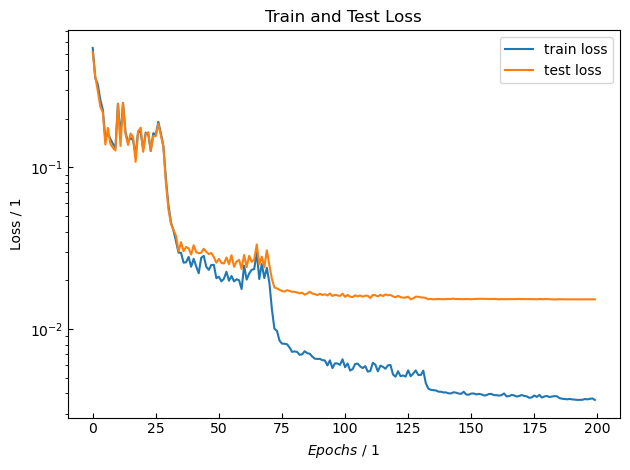

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Exportieren der Lernkurven zur Auswertung

In [11]:
np.savez('data/models/hyperparams/loss_005_009.npz', train_loss = train_loss, test_loss = test_loss)

#### Parity Plot

Training Dataset: R^2(H2) = 0.9999485043937105 , R^2(NH3) = 0.999941200572617
Test Dataset: R^2(H2) = 0.9995273040571176 , R^2(NH3) = 0.9990955342344235
Max Error Training: |x_H2 - x_H2,pred| = 0.018720539354942445 , |x_NH3 - x_NH3,pred| = 0.009244792829036286
Max Error Test: |x_H2 - x_H2,pred| = 0.013126935955593555 , |x_NH3 - x_NH3,pred| = 0.025317441828462572


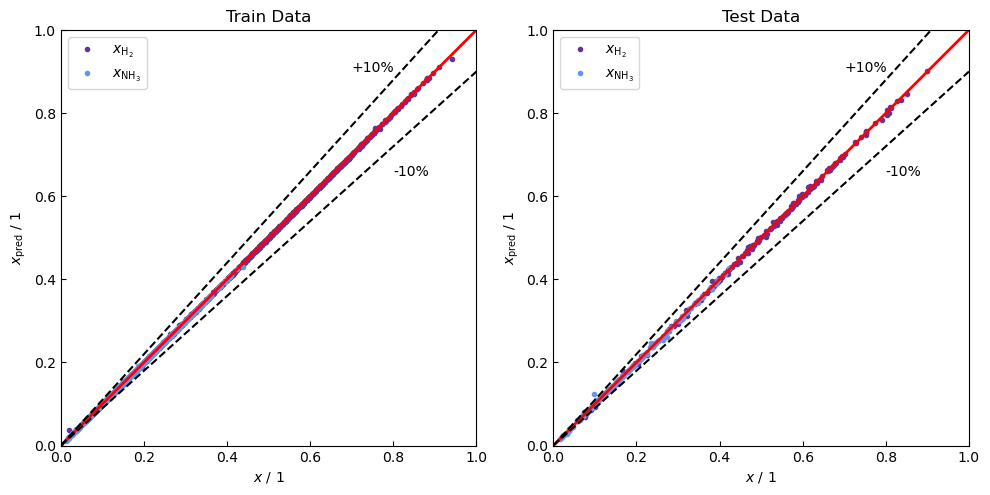

In [12]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

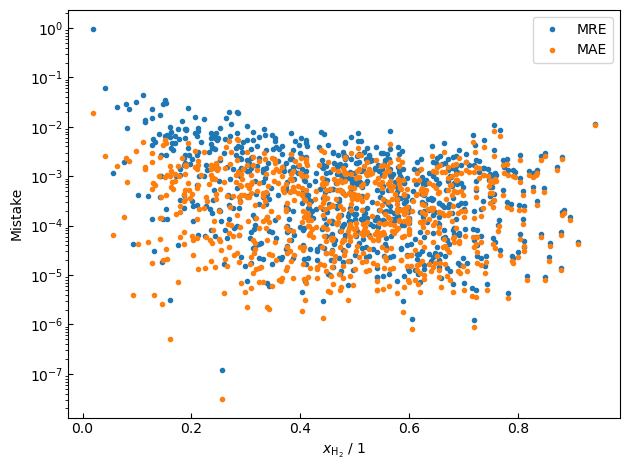

In [13]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

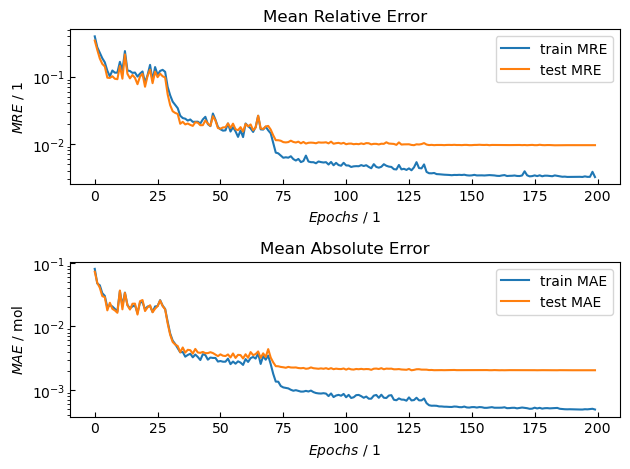

In [14]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

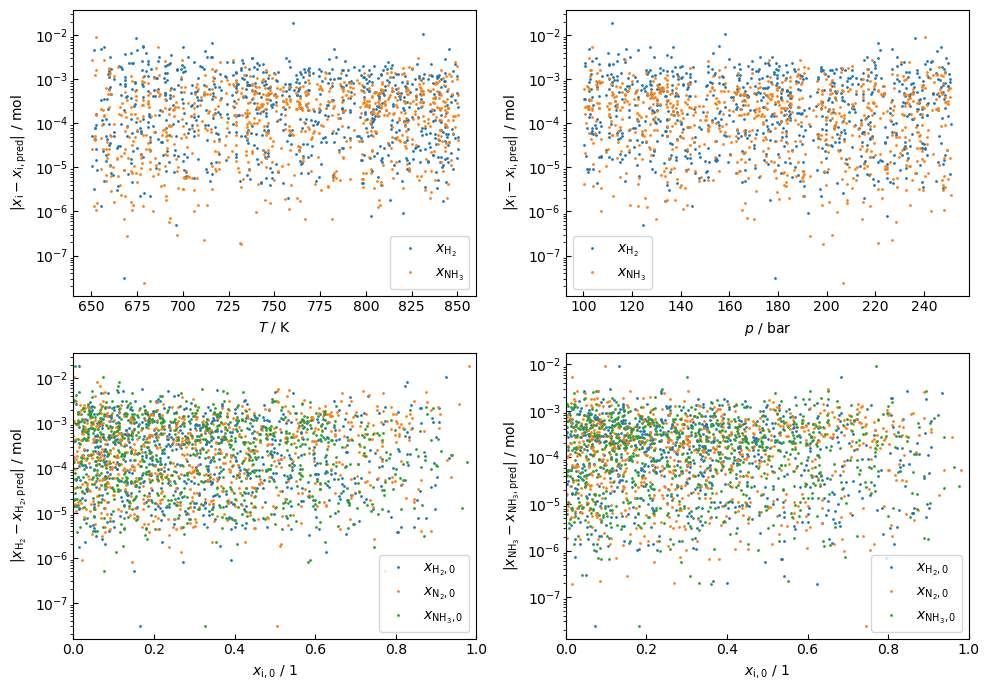

In [15]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

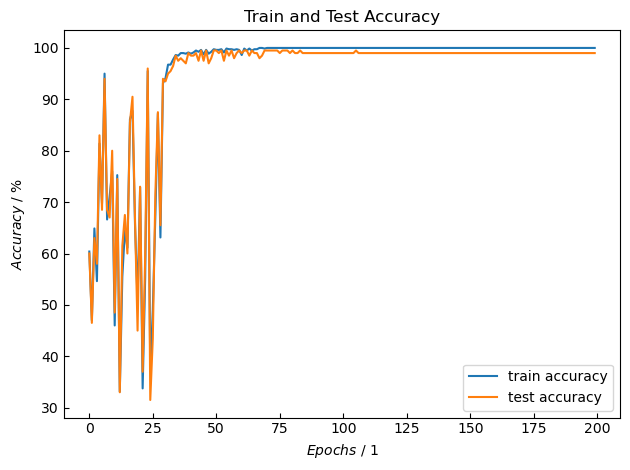

In [16]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-7.4183e-01,  1.1734e+00,  1.3456e-01, -1.0353e+00,  9.2615e-01],
        [-1.5820e-01, -9.7309e-04,  4.7619e-01, -1.1607e-01, -3.4870e-01],
        [-1.3796e+00,  1.3841e+00,  2.1320e+00, -1.1431e+00, -9.2400e-01],
        [-1.6270e+00,  9.4818e-01, -9.7588e-01, -1.0041e+00,  1.9839e+00],
        [-3.2986e-01, -1.0830e+00, -2.2871e-01,  1.6851e-01,  5.2223e-02],
        [ 8.7219e-01, -1.1286e+00, -9.8994e-01, -3.3050e-01,  1.3093e+00],
        [-6.5081e-01,  1.3536e+00,  2.1032e+00, -1.2638e+00, -7.7232e-01],
        [ 1.1344e+00,  1.3806e+00, -1.3393e+00,  2.2152e+00, -9.4977e-01],
        [-5.1265e-01,  9.0194e-01,  1.2347e-01, -1.4353e-01,  2.5528e-02],
        [ 7.4652e-01,  1.4261e+00, -1.0118e+00, -5.0536e-02,  1.0446e+00],
        [ 1.1368e+00,  7.1636e-01, -1.3729e+00, -1.0466e+00,  2.4171e+00],
        [-1.4496e+00,  1.7207e+00, -3.5878e-01, -1.3056e-01,  4.8554e-01],
        [-1.0963e+00,  1.4259e+00, -4.2807e-01, -3.2783e-01,  7.5517e-01],
        [ 7.9222e-01,  1.

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-0.1341,  0.1258, -0.0678, -0.0695,  0.4403],
         [ 0.1758, -0.1569, -0.3730,  0.0166, -0.3350],
         [-0.3521,  0.2633,  0.2852,  0.1002,  0.0177],
         [-0.4028,  0.3892, -0.3317, -0.0568,  0.1317],
         [ 0.4374, -0.0888,  0.0174,  0.3948,  0.3086],
         [-0.4671,  0.3029,  0.4714, -0.1692,  0.2369],
         [-0.2521,  0.1601,  0.1724,  0.0573, -0.0789],
         [ 0.4818, -0.4165,  0.0185,  0.4038,  0.0350],
         [-0.2508,  0.2828,  0.0585, -0.2762,  0.0557],
         [-0.2754,  0.0117,  0.2455, -0.1920,  0.1826],
         [ 0.3740, -0.0519, -0.0557,  0.0598, -0.2466],
         [-0.3850,  0.1092,  0.2481,  0.0586,  0.3308],
         [-0.5298,  0.0014,  0.0862,  0.2213, -0.3142],
         [-0.2020,  0.1262, -0.0891, -0.3574,  0.3456],
         [ 0.2721, -0.1758,  0.3365, -0.4504,  0.1294],
         [-0.3295, -0.2171,  0.2786,  0.3547,  0.0459],
         [ 0.3470,  0.0518, -0.2725, -0.5064, -0.2045],
         [-0.3173,  0.211

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.7287, 0.9427, 0.3296, 0.6805, 0.7036],
        [0.5321, 0.4555, 0.1233, 0.5604, 0.5402]])
tensor([[ 0.0184, -0.2056],
        [-0.0432, -0.2299]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-8.6265e-01,  4.5460e-01, -1.2893e+00,  4.2004e-01,  8.3602e-01],
        [-1.0007e+00,  6.0695e-01, -1.2187e+00,  2.3841e+00, -1.2407e+00],
        [ 7.4725e-02,  5.5401e-01, -6.2231e-01,  2.9287e-01,  3.1139e-01],
        [ 6.1973e-01,  2.7523e-01, -1.0969e-01, -1.1991e+00,  1.3332e+00],
        [-4.7997e-01,  2.0070e-01,  7.7842e-01, -2.3294e-01, -5.2585e-01],
        [ 1.0805e+00,  1.4381e+00, -3.8197e-01,  6.1884e-01, -2.5764e-01],
        [-7.9972e-01, -1.0352e+00, -2.5068e-01, -1.3865e-01,  3.8772e-01],
        [-9.3532e-01, -1.3773e+00,  8.4218e-01, -4.7557e-01, -3.4044e-01],
        [-7.3827e-01,  1.5948e+00, -3.1810e-01,  1.6572e+00, -1.3816e+00],
        [-1.5820e-01, -9.7309e-04,  4.7619e-01, -1.1607e-01, -3.4870e-01],
        [ 1.4001e+00, -1.8559e-01, -4.2667e-01,  1.1018e+00, -7.0742e-01],
        [ 1.1237e+00,  8.2756e-01,  7.3563e-04,  1.2689e+00, -1.2976e+00],
        [ 1.6121e+00,  5.5167e-01, -1.2638e-01, -6.5691e-01,  7.9544e-01],
        [-4.5049e-01, -1.

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()